In [ ]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import numpy as np
#from scipy.interpolate import interp2d
import pandas as pd 
from itertools import permutations, product, combinations
import idaes
from itertools import permutations, product

from fim_doe import *

import pyomo.common.unittest as unittest

In [ ]:
import cvxpy as cp

from reactor_kinetics import *

## FIM generator

In [ ]:
def generate_exp(t_set, CA0, T):  
    '''Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    '''
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [ ]:
def return_FIM(measure_pass):
    # Create model function
    createmod = create_model

    # discretization by Pyomo.DAE
    disc = disc_for_measure

    # Control time set [h]
    t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

    

    # design variable and its control time set
    dv_pass = {'CA0': [0],'T': t_control}

    t_test = [0.125, 0.375, 0.625, 0.875]

    
    measure_class =  Measurements(measure_pass)

    # Define parameter nominal value 
    parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}
    
    # empty prior
    prior_all = np.zeros((4,4))

    prior_pass=np.asarray(prior_all)

    print('The prior information FIM:', prior_pass)
    

    # choose from 'sequential_finite', 'direct_kaug'
    # 'sequential_sipopt', 'sequential_kaug' is also available
    sensi_opt = 'sequential_finite'
    #sensi_opt = 'direct_kaug'

    # model option
    if sensi_opt == 'direct_kaug':
        args_ = [False]
    else:
        args_ = [True]


    # Define experiments
    exp1 = generate_exp(t_control, 5, [570, 300, 300, 300, 300, 300, 300, 300, 300])
    
    doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_, verbose=False)


    result = doe_object.compute_FIM(exp1,mode=sensi_opt, FIM_store_name = 'dynamic.csv', scale_nominal_param_value=True, 
                                    store_output = 'store_output', read_output=None,tee_opt=False,
                                    formula='central')


    result.calculate_FIM(doe_object.design_values)
    
    
    print('======Result summary======')
    print('Four design criteria log10() value:')
    print('A-optimality:', np.log10(result.trace))
    print('D-optimality:', np.log10(result.det))
    print('E-optimality:', np.log10(result.min_eig))
    print('Modified E-optimality:', np.log10(result.cond))
    
    return result.FIM, result.jaco_information

In [ ]:
# Create measurement object
# Measurement time points [h]
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

measure_pass = {'C':{'CA': t_measure, 'CB': t_measure, 'CC': t_measure}}
#measure_pass = {'C':{'CC': t_test}}

In [ ]:
fim1, jaco1 = return_FIM(measure_pass)
print(jaco1)

### Jacobian generator

In [ ]:
jaco = pd.DataFrame(jaco1)
jaco.to_csv('./kinetics_fim/Q.csv')

### FIM generator

In [ ]:
FIM_set = []

def to_dataframe(fim_list):
    
    fim_dict = {'P1': fim_list[0], 
               'P2': fim_list[1],
               'P3': fim_list[2], 
               'P4': fim_list[3]
               }
    fim_frame = pd.DataFrame(fim_dict)
    
    return fim_frame

In [ ]:
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
#t_measure = [0]

#measure_pass = {'C':{'CA': t_measure, 'CB': t_measure, 'CC': t_measure}}
#measure_pass = {'C':{'CC': t_test}}

for idx, i in enumerate(t_measure):
    measure_pass = {'C':{'CA': [i]}}
    fim1, _ = return_FIM(measure_pass)
    FIM_set.append(fim1)
    print('FIM for CA, time ', i, ':', fim1)
    fim1_dataframe = to_dataframe(fim1)
    fim1_dataframe.to_csv('./kinetics_fim/CA_'+str(idx)+'.csv')
    
for idx, i in enumerate(t_measure):
    measure_pass = {'C':{'CB': [i]}}
    fim1, _ = return_FIM(measure_pass)
    FIM_set.append(fim1)
    print('FIM for CB, time ', i, ':', fim1)
    fim1_dataframe = to_dataframe(fim1)
    fim1_dataframe.to_csv('./kinetics_fim/CB_'+str(idx)+'.csv')
    
for idx, i in enumerate(t_measure):
    measure_pass = {'C':{'CC': [i]}}
    fim1, _ = return_FIM(measure_pass)
    FIM_set.append(fim1)
    print('FIM for CC, time ', i, ':', fim1)
    fim1_dataframe = to_dataframe(fim1)
    fim1_dataframe.to_csv('./kinetics_fim/CC_'+str(idx)+'.csv')

In [ ]:
print(np.shape(FIM_set))

print(FIM_set[0][1,1])

print(FIM_set)

## FIM reader

In [ ]:
def dataframe_return(data):
    fim1 = []
    fim1.append(data['P1'].to_list())
    fim1.append(data['P2'].to_list())
    fim1.append(data['P3'].to_list())
    fim1.append(data['P4'].to_list())
    
    return fim1 

In [ ]:
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

#t_measure = [0.125]



def FIM_reader(rank='onebyone'):
    
    FIM_set = []
    
    if rank=='onebyone':
        for idx, i in enumerate(t_measure):
            fim1_data = pd.read_csv('./kinetics_fim/CA_' + str(idx)+'.csv')
            
            fim1 = dataframe_return(fim1_data)
            FIM_set.append(fim1)
            
            fim2_data = pd.read_csv('./kinetics_fim/CB_' + str(idx)+'.csv')
            
            fim2 = dataframe_return(fim2_data)
            FIM_set.append(fim2)
            
            fim3_data = pd.read_csv('./kinetics_fim/CC_' + str(idx)+'.csv')
            
            fim3 = dataframe_return(fim3_data)
            FIM_set.append(fim3)
            
    elif rank=='onealong':
        for idx, i in enumerate(t_measure):
            fim1_data = pd.read_csv('./kinetics_fim/CA_' + str(idx)+'.csv')
            
            fim1 = dataframe_return(fim1_data)
            FIM_set.append(fim1)
            
        for idx, i in enumerate(t_measure):
            fim2_data = pd.read_csv('./kinetics_fim/CB_' + str(idx)+'.csv')
            
            fim2 = dataframe_return(fim2_data)
            FIM_set.append(fim2)
            
        for idx, i in enumerate(t_measure):
            fim3_data = pd.read_csv('./kinetics_fim/CC_' + str(idx)+'.csv')
            
            fim3 = dataframe_return(fim3_data)
            FIM_set.append(fim3)
            
            
    return FIM_set
        
FIM_set = FIM_reader(rank='onealong')
print(np.shape(FIM_set))
print(FIM_set[0][1][1])

In [ ]:
TotalF = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        TotalF[i,j] = sum(FIM_set[k][i][j] for k in range(27))
        
print(TotalF)

print(np.trace(TotalF))
print(np.linalg.det(TotalF))
print(np.linalg.eigvals(TotalF))

### Jacobian reader

In [ ]:
jaco_info = pd.read_csv('./kinetics_fim/Q.csv')

#print(jaco_info)


Q_stack = []

for i in range(27):
    
    Q_res = [jaco_info['A1'].iloc[i], jaco_info['A2'].iloc[i], jaco_info['E1'].iloc[i], jaco_info['E2'].iloc[i]]
    
    
    Q_stack.append(Q_res)
    
print(Q_stack)

### FIM verificator

In [ ]:
#optimize_sol = [ 0, 0, 0, 
#                1, 1, 1, 1, 1, 1,
#                1, 1, 1, 1, 1, 1, 
#                0, 1, 1, 0, 1, 1,
#                0, 1, 1, 0, 1, 1]


SelectF = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        SelectF[i,j] = sum(FIM_set[k][i,j]*yi for k, yi in enumerate(optimize_sol))
        
print(SelectF)

print(np.trace(SelectF))
print(np.linalg.det(SelectF))
print(np.linalg.eigvals(SelectF))

## CVXPY problem

no variance

In [ ]:
no_res = 27

In [ ]:
def eval_fim(yi):
     
    fim = sum(yy*FIM_set[idx] for idx, yy in enumerate(yi))
    #fim = cp.bmat(FIM_set)
        
    return fim 

def a_opt(yi):
    fim = eval_fim(yi)
    #return cp.matrix_frac(np.identity(fim.shape==[0]), fim)
    return cp.trace(fim)
    
def d_opt(yi):
    fim = eval_fim(yi)
    return cp.log_det(fim)

def e_opt(yi):
    fim = eval_fim(yi)
    return -cp.lambda_min(fim)

In [ ]:
yi = cp.Variable(no_res, nonneg=True)

p_cons = [cp.sum(yi) <= 20]

for i in yi:
    p_cons += [i<=1]

obj = cp.Maximize(d_opt(yi))

problem = cp.Problem(obj, p_cons)

In [ ]:
print('Optimal value:', problem.solve(verbose=True))

print(yi.value)

## cvxpy problem 

With variance

In [ ]:
def eval_fim(ya, yb, yc):
     
    fim = sum(yy1*FIM_set[idx] for idx, yy1 in enumerate(ya))+sum(yy2*FIM_set[idx+9]*0.25 for idx, yy2 in enumerate(yb)) + sum(yy3*FIM_set[idx+18]*0.25 for idx, yy3 in enumerate(yc))
                
    return fim 

def a_opt(yi):
    fim = eval_fim(yi)
    #return cp.matrix_frac(np.identity(fim.shape==[0]), fim)
    return cp.trace(fim)
    
def d_opt(ya, yb, yc):
    fim = eval_fim(ya, yb, yc)
    return cp.log_det(fim)

def e_opt(yi):
    fim = eval_fim(yi)
    return -cp.lambda_min(fim)

In [ ]:
no_res_unit = 9

ya = cp.Variable(no_res_unit, nonneg=True)
yb = cp.Variable(no_res_unit, nonneg=True)
yc = cp.Variable(no_res_unit, nonneg=True)

p_cons = [cp.sum(ya*10) + cp.sum(yb*6) + cp.sum(yc*6) <= 80]

for i in ya:
    p_cons += [i<=1]
for j in yb:
    p_cons += [j<=1]
for d in yc:
    p_cons += [d<=1]
    
obj = cp.Maximize(d_opt(ya, yb, yc))

problem = cp.Problem(obj, p_cons)



In [ ]:
print('First time: Optimal value:', problem.solve(verbose=True, max_iters=150000))

print('Second time: Optimal value:', problem.solve(verbose=True, warm_start = True))

In [ ]:
print(ya.value)
print(yb.value)
print(yc.value)

## CVXPY problem - with covariance 

### Continuous 

In [ ]:
# variance 
variance = [1, # var_CA^2
            4, # var_CB^2
            8  # var_CC^2
           ]
covariance = [ 0.1, # cov_CA_CB | ti, 
               0.1, # cov_CA_CC | ti, 
               0.5 # cov_CB_CC | ti
]

# construct Sigma
sigma = np.zeros((27, 27))

for i in range(27):
    #for j in range(27):
        
        #if i==j:
    if i<9:
        sigma[i,i]=variance[0]
        sigma[i,i+9]=covariance[0]
        sigma[i,i+18]=covariance[1]
    elif 9<= i < 18:
        sigma[i,i]=variance[1]
        sigma[i,i-9]=covariance[0]
        sigma[i,i+9]=covariance[2]
    elif i>=18:
        sigma[i,i]=variance[2]
        sigma[i,i-18]=covariance[1]
        sigma[i,i-9]=covariance[2]
                
            
# check eigen values to make sure it's PSD 
print(np.linalg.eigvals(sigma))



In [ ]:
sigma_inv = np.linalg.inv(sigma)

In [ ]:
for i in range(9):
    for j in range(9):
        if sigma_inv[i,j] != sigma_inv[j,i]:
            print('wrong')
            
#print(sigma_inv)

print(np.linalg.eigvals(sigma_inv))
# verify: 

Q_array = np.asarray(Q_stack)

fim = Q_array.T@sigma_inv@Q_array

print(fim)
print('trace:', np.trace(fim))
print('det:', np.linalg.det(fim))
print('logdet:', np.log(np.linalg.det(fim)))
print('eig:', np.linalg.eigvals(fim))

In [ ]:
# construct FIMs. Expect 27*27 FIMs
# No 
print(np.shape(Q_stack))

Q_matrix = []
for i in range(27):
    Q_matrix.append(np.asarray(Q_stack[i]).reshape((4,1)))
# Q: [CA|t1, ..., CA|tN, CB|ti, ..., CC|ti, ...]

FIM_collection = []

for i in range(9):
    # yCA, CA
    mat = sigma_inv[i,i]*Q_matrix[i]@Q_matrix[i].T
    FIM_collection.append(mat)

for i in range(9):
    # yCA, CB
    FIM_collection.append(sigma_inv[i,i+9]*Q_matrix[i]@Q_matrix[i+9].T)

for i in range(9):
    # YCA, CC
    FIM_collection.append(sigma_inv[i,i+18]*Q_matrix[i]@Q_matrix[i+18].T)

for i in range(9,18): 
    FIM_collection.append(sigma_inv[i,i]*Q_matrix[i]@Q_matrix[i].T)

for i in range(9,18): 
    FIM_collection.append(sigma_inv[i,i-9]*Q_matrix[i]@Q_matrix[i-9].T)

for i in range(9,18): 
    FIM_collection.append(sigma_inv[i,i+9]*Q_matrix[i]@Q_matrix[i+9].T)

for i in range(18, 27): 
    FIM_collection.append(sigma_inv[i,i]*Q_matrix[i]@Q_matrix[i].T)

for i in range(18, 27): 
    FIM_collection.append(sigma_inv[i,i-18]*Q_matrix[i]@Q_matrix[i-18].T)

for i in range(18, 27): 
    FIM_collection.append(sigma_inv[i,i-9]*Q_matrix[i]@Q_matrix[i-9].T)
        

print(np.shape(FIM_collection))

In [ ]:
def compute():
    #ya = [0.5, 0.238, 0, 0.26, 0, 0, 0, 0, 0]
    yb = [0, 0.21, 0, 0, 0, 0, 0, 0, 0.29] 
    yc = [0, 0.36, 0, 0, 0, 0, 0, 0, 0.14]
    ya = [0.5]+[1]*8
    yb = [0.5]+[1]*8
    yc = [0.5]+[1]*8
    yac = [0.5]+[1]*6 + [0,0]
    yab = [0.5]+[1]*8
    ybc = [0.5]+[1]*8

    print(ya)

    #print(FIM_collection[33])

    fim = sum(ya1*FIM_collection[idx] for idx, ya1 in enumerate(ya)) \
        + sum(yb1*FIM_collection[idx+27] for idx, yb1 in enumerate(yb)) \
        + sum(yc1*FIM_collection[idx+54] for idx, yc1 in enumerate(yc)) \
        + sum(yab1*FIM_collection[idx+9] for idx, yab1 in enumerate(yab)) \
        + sum(yab1*FIM_collection[idx+36] for idx, yab1 in enumerate(yab)) \
        + sum(yac1*FIM_collection[idx+18] for idx, yac1 in enumerate(yac)) \
        + sum(yac1*FIM_collection[idx+63] for idx, yac1 in enumerate(yac)) \
        + sum(ybc1*FIM_collection[idx+45] for idx, ybc1 in enumerate(ybc)) \
        + sum(ybc1*FIM_collection[idx+72] for idx, ybc1 in enumerate(ybc))

    return fim

fim = compute()
    
print(fim)
print('trace:', np.trace(fim))
print('det:', np.linalg.det(fim))
print('logdet:', np.log(np.linalg.det(fim)))
print('eig:', np.linalg.eigvals(fim))

In [ ]:
def eval_fim(ya, yb, yc, yab, yac, ybc):
     
    fim = sum(ya1*FIM_collection[idx] for idx, ya1 in enumerate(ya)) \
    + sum(yb1*FIM_collection[idx+27] for idx, yb1 in enumerate(yb)) \
    + sum(yc1*FIM_collection[idx+54] for idx, yc1 in enumerate(yc)) \
    + sum(yab1*FIM_collection[idx+9] for idx, yab1 in enumerate(yab)) \
    + sum(yab1*FIM_collection[idx+36] for idx, yab1 in enumerate(yab)) \
    + sum(yac1*FIM_collection[idx+18] for idx, yac1 in enumerate(yac)) \
    + sum(yac1*FIM_collection[idx+63] for idx, yac1 in enumerate(yac)) \
    + sum(ybc1*FIM_collection[idx+45] for idx, ybc1 in enumerate(ybc)) \
    + sum(ybc1*FIM_collection[idx+72] for idx, ybc1 in enumerate(ybc))
    
    return fim 

def a_opt(ya, yb, yc, yab, yac, ybc):
    fim = eval_fim(ya, yb, yc, yab, yac, ybc)
    return cp.trace(fim)
    
def d_opt(ya, yb, yc, yab, yac, ybc):
    fim = eval_fim(ya, yb, yc, yab, yac, ybc)
    return cp.log_det(fim)

def e_opt(ya, yb, yc, yab, yac, ybc):
    fim = eval_fim(ya, yb, yc, yab, yac, ybc)
    return -cp.lambda_min(fim)

In [ ]:
no_res_unit = 9

ya = cp.Variable(no_res_unit, nonneg=True)
yb = cp.Variable(no_res_unit, nonneg=True)
yc = cp.Variable(no_res_unit, nonneg=True)
yab = cp.Variable(no_res_unit, nonneg=True)
yac = cp.Variable(no_res_unit, nonneg=True)
ybc = cp.Variable(no_res_unit, nonneg=True)

p_cons = [cp.sum(ya*10) + cp.sum(yb*6) + cp.sum(yc*6) <= 170]

#p_cons = []

for i in ya:
    p_cons += [i<=1]
for j in yb:
    p_cons += [j<=1]
for d in yc:
    p_cons += [d<=1]


#for x in yab:
p_cons += [yab[i] <= ya[i] for i, idx in enumerate(ya)]
p_cons += [yab[i] <= yb[i] for i, idx in enumerate(yb)]
p_cons += [yac[i] <= ya[i] for i, idx in enumerate(ya)]
p_cons += [yac[i] <= yc[i] for i, idx in enumerate(yc)]
p_cons += [ybc[i] <= yb[i] for i, idx in enumerate(yb)]
p_cons += [ybc[i] <= yc[i] for i, idx in enumerate(yc)]

p_cons += [ya[i]+yb[i]-1<=yab[i] for i, idx in enumerate(ya)]
p_cons += [ya[i]+yc[i]-1<=yac[i] for i, idx in enumerate(ya)]
p_cons += [yb[i]+yc[i]-1<=ybc[i] for i, idx in enumerate(yb)]
    
obj = cp.Maximize(d_opt(ya, yb, yc, yab, yac, ybc))

problem = cp.Problem(obj, p_cons)


In [ ]:
print('First time: Optimal value:', problem.solve(verbose=True))

In [ ]:
print(ya.value)
print(yb.value)
print(yc.value)
print(yab.value)
print(yac.value)
print(ybc.value)

## Covariance without the initial measurement

In [ ]:
jaco_info = pd.read_csv('./kinetics_fim/Q.csv')

#print(jaco_info)


Q_stack = []

for i in range(1,9):
    
    Q_res = [jaco_info['A1'].iloc[i], jaco_info['A2'].iloc[i], jaco_info['E1'].iloc[i], jaco_info['E2'].iloc[i]]
    
    Q_stack.append(Q_res)
    
for i in range(10,18):
    
    Q_res = [jaco_info['A1'].iloc[i], jaco_info['A2'].iloc[i], jaco_info['E1'].iloc[i], jaco_info['E2'].iloc[i]]
    
    Q_stack.append(Q_res)
    
for i in range(19,27):
    
    Q_res = [jaco_info['A1'].iloc[i], jaco_info['A2'].iloc[i], jaco_info['E1'].iloc[i], jaco_info['E2'].iloc[i]]
    
    Q_stack.append(Q_res)
    
print(Q_stack)
    
print(np.shape(Q_stack))

In [ ]:
# variance 
variance = [1, # var_CA^2
            4, # var_CB^2
            8  # var_CC^2
           ]
covariance = [ 0.1, # cov_CA_CB | ti, 
               0.1, # cov_CA_CC | ti, 
               0.5 # cov_CB_CC | ti
]

# construct Sigma
sigma = np.zeros((24, 24))

for i in range(24):
    #for j in range(27):
        
        #if i==j:
    if i<8:
        sigma[i,i]=variance[0]
        sigma[i,i+8]=covariance[0]
        sigma[i,i+16]=covariance[1]
    elif 8<= i < 16:
        sigma[i,i]=variance[1]
        sigma[i,i-8]=covariance[0]
        sigma[i,i+8]=covariance[2]
    elif i>=16:
        sigma[i,i]=variance[2]
        sigma[i,i-16]=covariance[1]
        sigma[i,i-8]=covariance[2]
                
            
# check eigen values to make sure it's PSD 
print(np.linalg.eigvals(sigma))

In [ ]:
sigma_inv = np.linalg.inv(sigma)

In [ ]:
print(np.shape(Q_stack))

Q_matrix = []
for i in range(24):
    Q_matrix.append(np.asarray(Q_stack[i]).reshape((4,1)))
# Q: [CA|t1, ..., CA|tN, CB|ti, ..., CC|ti, ...]

FIM_collection = []

for i in range(8):
    # yCA, CA
    mat = sigma_inv[i,i]*Q_matrix[i]@Q_matrix[i].T
    FIM_collection.append(mat)

for i in range(8):
    # yCA, CB
    FIM_collection.append(sigma_inv[i,i+8]*Q_matrix[i]@Q_matrix[i+8].T)

for i in range(8):
    # YCA, CC
    FIM_collection.append(sigma_inv[i,i+16]*Q_matrix[i]@Q_matrix[i+16].T)

for i in range(8,16): 
    FIM_collection.append(sigma_inv[i,i]*Q_matrix[i]@Q_matrix[i].T)

for i in range(8,16): 
    FIM_collection.append(sigma_inv[i,i-8]*Q_matrix[i]@Q_matrix[i-8].T)

for i in range(8,16): 
    FIM_collection.append(sigma_inv[i,i+8]*Q_matrix[i]@Q_matrix[i+8].T)

for i in range(16, 24): 
    FIM_collection.append(sigma_inv[i,i]*Q_matrix[i]@Q_matrix[i].T)

for i in range(16, 24): 
    FIM_collection.append(sigma_inv[i,i-16]*Q_matrix[i]@Q_matrix[i-16].T)

for i in range(16, 24): 
    FIM_collection.append(sigma_inv[i,i-8]*Q_matrix[i]@Q_matrix[i-8].T)
        

print(np.shape(FIM_collection))

In [ ]:
def eval_fim(ya, yb, yc, yab, yac, ybc):
     
    fim = sum(ya1*FIM_collection[idx] for idx, ya1 in enumerate(ya)) \
    + sum(yb1*FIM_collection[idx+24] for idx, yb1 in enumerate(yb)) \
    + sum(yc1*FIM_collection[idx+48] for idx, yc1 in enumerate(yc)) \
    + sum(yab1*FIM_collection[idx+8] for idx, yab1 in enumerate(yab)) \
    + sum(yab1*FIM_collection[idx+32] for idx, yab1 in enumerate(yab)) \
    + sum(yac1*FIM_collection[idx+16] for idx, yac1 in enumerate(yac)) \
    + sum(yac1*FIM_collection[idx+56] for idx, yac1 in enumerate(yac)) \
    + sum(ybc1*FIM_collection[idx+40] for idx, ybc1 in enumerate(ybc)) \
    + sum(ybc1*FIM_collection[idx+64] for idx, ybc1 in enumerate(ybc))
    
    return fim 

def a_opt(ya, yb, yc, yab, yac, ybc):
    fim = eval_fim(ya, yb, yc, yab, yac, ybc)
    return cp.trace(fim)
    
def d_opt(ya, yb, yc, yab, yac, ybc):
    fim = eval_fim(ya, yb, yc, yab, yac, ybc)
    return cp.log_det(fim)

def e_opt(ya, yb, yc, yab, yac, ybc):
    fim = eval_fim(ya, yb, yc, yab, yac, ybc)
    return -cp.lambda_min(fim)

In [ ]:
no_res_unit = 8

ya = cp.Variable(no_res_unit, nonneg=True)
yb = cp.Variable(no_res_unit, nonneg=True)
yc = cp.Variable(no_res_unit, nonneg=True)
yab = cp.Variable(no_res_unit, nonneg=True)
yac = cp.Variable(no_res_unit, nonneg=True)
ybc = cp.Variable(no_res_unit, nonneg=True)

p_cons = [cp.sum(ya*10) + cp.sum(yb*6) + cp.sum(yc*6) <= 170]

#p_cons = []

for i in ya:
    p_cons += [i<=1]
for j in yb:
    p_cons += [j<=1]
for d in yc:
    p_cons += [d<=1]


#for x in yab:
p_cons += [yab[i] <= ya[i] for i, idx in enumerate(ya)]
p_cons += [yab[i] <= yb[i] for i, idx in enumerate(yb)]
p_cons += [yac[i] <= ya[i] for i, idx in enumerate(ya)]
p_cons += [yac[i] <= yc[i] for i, idx in enumerate(yc)]
p_cons += [ybc[i] <= yb[i] for i, idx in enumerate(yb)]
p_cons += [ybc[i] <= yc[i] for i, idx in enumerate(yc)]

p_cons += [ya[i]+yb[i]-1<=yab[i] for i, idx in enumerate(ya)]
p_cons += [ya[i]+yc[i]-1<=yac[i] for i, idx in enumerate(ya)]
p_cons += [yb[i]+yc[i]-1<=ybc[i] for i, idx in enumerate(yb)]
    
obj = cp.Maximize(d_opt(ya, yb, yc, yab, yac, ybc))

problem = cp.Problem(obj, p_cons)


In [ ]:
print('First time: Optimal value:', problem.solve(verbose=True))

In [ ]:
print(ya.value)
print(yb.value)
print(yc.value)
print(yab.value)
print(yac.value)
print(ybc.value)

## Result reader

In [ ]:
time_list = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

def result(li1, li2, li3, verbose=True):
    
  
    rep1 = []
    
    for i, res in enumerate(li1):
        if res >= 0.99:
            #print(str(time_list[i]) + ': yes')
            rep1.append(1)            
        elif res <= 0.01:
            #print(str(time_list[i]) + ': no')
            rep1.append(0)
        else: 
            #print(str(time_list[i]) + ': '+str(res))
            rep1.append(res)

    
    rep2 = []
    
    for i, res in enumerate(li2):
        if res >= 0.99:
            #print(str(time_list[i]) + ': yes')
            rep2.append(1)        
        elif res <= 0.01:
            #print(str(time_list[i]) + ': no')
            rep2.append(0)
        else: 
            #print(str(time_list[i]) + ': '+str(res))
            rep2.append(res)
            
    
    rep3 = []
    
    for i, res in enumerate(li3):
        if res >= 0.99:
            #print(str(time_list[i]) + ': yes')
            rep3.append(1)
        elif res <= 0.01:
            #print(str(time_list[i]) + ': no')
            rep3.append(0)
        else: 
            #print(str(time_list[i]) + ': '+str(res))
            rep3.append(res)
            
            
    if verbose:
        print('CA:', rep1)
        print('CB:', rep2)
        print('CC:', rep3)
            
    return rep1, rep2, rep3

yaa, ybb, ycc = result(ya.value, yb.value, yc.value)
yab1, yac1, ybc1 = result(yab.value, yac.value, ybc.value, verbose=False)

def check(ya, yb, yc, yab, yac, ybc):
    
    for i in range(8):
        
        if yab[i] != min(ya[i], yb[i]):
            print('constraint violated: yab', i)
            
        if yac[i] != min(ya[i], yc[i]):
            print('constraint violated: yac', i)
            
        if ybc[i] != min(yc[i], yb[i]):
            print('constraint violated: ybc', i)


    
def estimate_cost(li1, li2, li3):
    print('cost:', sum(li1)*10 + sum(li2)*6 + sum(li3)*6)
    
estimate_cost(yaa, ybb, ycc)
#check(yaa, ybb, ycc, yab1, yac1, ybc1)
print(yab1)
print(yac1)
print(ybc1)

## round 

In [ ]:
def compute(ya, yb, yc, yab, yac, ybc):

    #print(FIM_collection[33])

    fim = sum(ya1*FIM_collection[idx] for idx, ya1 in enumerate(ya)) \
        + sum(yb1*FIM_collection[idx+24] for idx, yb1 in enumerate(yb)) \
        + sum(yc1*FIM_collection[idx+48] for idx, yc1 in enumerate(yc)) \
        + sum(yab1*FIM_collection[idx+8] for idx, yab1 in enumerate(yab)) \
        + sum(yab1*FIM_collection[idx+32] for idx, yab1 in enumerate(yab)) \
        + sum(yac1*FIM_collection[idx+16] for idx, yac1 in enumerate(yac)) \
        + sum(yac1*FIM_collection[idx+56] for idx, yac1 in enumerate(yac)) \
        + sum(ybc1*FIM_collection[idx+40] for idx, ybc1 in enumerate(ybc)) \
        + sum(ybc1*FIM_collection[idx+64] for idx, ybc1 in enumerate(ybc))

    return fim



In [ ]:
def generate_cov(la1, lb2, lc3):
    
    lab = []
    
    lac = []
    
    lbc = []
    
    for i in range(8):
        lab.append(min(la1[i], lb2[i]))
        lac.append(min(la1[i], lc3[i]))
        lbc.append(min(lb2[i], lc3[i]))
        
    return lab, lac, lbc

In [ ]:
ya0 = [1, 1, 1, 1, 1, 1, 1, 1]
yb0 = [1, 1, 1, 1, 1, 1, 1, 1]
yc0 = [1, 1, 1, 1, 1, 1, 1, 1]

estimate_cost(ya0, yb0, yc0)
print(sum([sum(ya0), sum(yb0), sum(yc0)]))

yab0, yac0, ybc0 = generate_cov(ya0, yb0, yc0)
print('yab:', yab0)
print('yac:', yac0)
print('ybc:', ybc0)

In [ ]:
fim = compute(ya0, yb0, yc0, yab0, yac0, ybc0)
    
print(fim)
print('trace:', np.trace(fim))
print('det:', np.linalg.det(fim))
print('logdet:', np.log(np.linalg.det(fim)))
print('eig:', np.linalg.eigvals(fim))

## figure 

In [1]:
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
budget = np.linspace(50, 180, 14)
print(budget)

no_m = [7,8,9,11,12,14,15,17,18,20,21,22,23,24]

ln_det = [-0.46, 0.1255, 0.452, 0.9326, 1.2987,
         1.6275, 1.7816, 2.0136, 2.2191, 2.3738, 
         2.4847, 2.5439, 2.6023, 2.6324] 


[ 50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170. 180.]


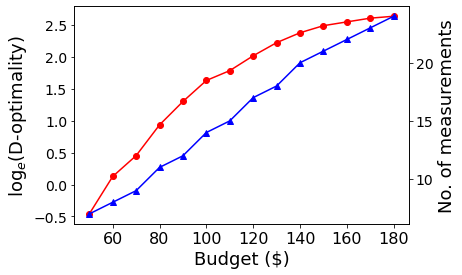

In [27]:
fig, ax = plt.subplots()

line1, =ax.plot(budget, ln_det, marker='o', color="red", label='D-optimality')
ax.set_xlabel('Budget ($)', fontsize=18)
ax.set_ylabel('log$_e$(D-optimality)', fontsize=18)
plt.xticks(fontsize=16)
ax.tick_params(axis='y', labelsize=14)

ax2 = ax.twinx()
line2, =ax2.plot(budget, no_m, marker='^', color="blue", label='No. of measurements')
ax2.set_ylabel('No. of measurements', fontsize=18)
ax2.tick_params(axis='y', labelsize=14)

#ax.legend(handles=[line1, line2])
plt.show()

fig.savefig('twinx.jpg',
            format='jpeg',
            dpi=200,
            bbox_inches='tight')

### tests

In [ ]:

test = [[1,0,0,5,0,0,9,0,0],
        [0,1,0,0,5,0,0,9,0],
        [0,0,1,0,0,5,0,0,9],
        [5,0,0,4,0,0,6,0,0],
        [0,5,0,0,4,0,0,6,0],
        [0,0,5,0,0,4,0,0,6],
        [9,0,0,6,0,0,4,0,0],
        [0,9,0,0,6,0,0,4,0],
        [0,0,9,0,0,6,0,0,4]]

test1 = np.asarray(test)

In [ ]:
print(np.linalg.inv(test1))